In [1]:
import numpy as np
import cv2
import glob
import time
import pickle
from collections import deque
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
# from sklearn.cross_validation import train_test_split  # for scikit-learn version <= 0.17
from sklearn.model_selection import train_test_split  # if you are using scikit-learn >= 0.18
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

from includes.car_classification import *
from includes.car_detection import *
from includes.lanes_camera_calibration import *
from includes.lanes_detection import *

## Lanes

In [ ]:
filename = 'test_images/test1.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

mtx, dist = camera_calibration(img_size)

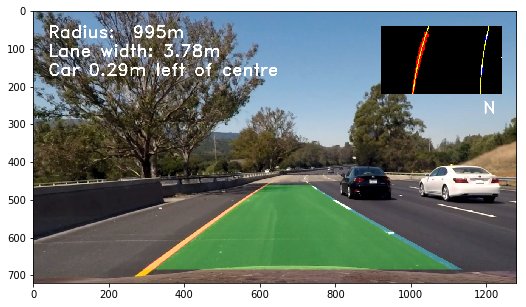

In [2]:
# Load camera calibration parameters
cal = pickle.load(open("camera_calibration/calibration.p", "rb"))
mtx = cal["mtx"]
dist = cal["dist"]

# Load test images
# images = glob.glob('test_images/*.jpg')
# images = ['test_images/straight_lines1.jpg']
images = ['test_images/test6.jpg']
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Test only the image processing pipeline
    if 0:
        undistorted, processed, M, Minv = image_processing_pipeline(img, mtx, dist)
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original')

        ax2.imshow(processed, cmap='gray')
        ax2.set_title('Processed')
        ax2.grid(True)
        
    # Test the whole pipeline
    if 1:
        lane_detector = LaneDetection(mtx=mtx,
                                      dist=dist)
        output = lane_detector.pipeline(img)
        f, ax = plt.subplots(1, 1, figsize=(10,5))
        ax.imshow(output)
        

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

filename = "videos/project_video.mp4"
# filename = "test_videos/challenge_video.mp4"
# filename = "test_videos/harder_challenge_video.mp4"
clip = VideoFileClip(filename)
white_output = filename[:-4] + '_lanes.mp4'

# Video boundaries
start_second = 4
end_second = 6

# Variables used by function "pipeline"
lane_detector = LaneDetection(mtx=mtx,
                              dist=dist)
white_clip = clip.fl_image(lane_detector.pipeline)#.subclip(start_second,end_second)

%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video videos/project_video_lanes.mp4
[MoviePy] Writing video videos/project_video_lanes.mp4


100%|█████████▉| 1260/1261 [05:23<00:00,  3.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_lanes.mp4 

CPU times: user 13min 30s, sys: 5.86 s, total: 13min 36s
Wall time: 5min 23s


## Cars

In [ ]:
cars = glob.glob('car_classification_datasets/vehicles/**/*.png', recursive=True)
notcars = glob.glob('car_classification_datasets/non-vehicles/**/*.png', recursive=True)
print('Car images: {}'.format(len(cars)))
print('Non-car images: {}'.format(len(notcars)))

# sample_size = 100
sample_size = None
if sample_size is not None:
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]
    
## Feature parameters
parameters = {'colorspace': 'YCrCb',            # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
              'hog_channel': 'ALL',             # Can be 0, 1, 2, or "ALL"
              'hog_orient': 9,                  # HOG possible orientations    9 11
              'hog_pix_per_cell': 8,            # HOG number of px per cell    8 16
              'hog_cell_per_block': 2,          # HOG number of cells per block
              'spatial_size': (32, 32),         # Spatial binning dimensions
              'histogram_bins': 32}             # Number of histogram bins

if 0:
    # Extract features for writeup
    extract_features_from_image_list(cars[100:106], show_intermediate=True)

if 1:
    train_classifier(cars, notcars, parameters, "model_linearsvc_9_8")

In [ ]:
# Load classifier and scaler
model = pickle.load(open("models/model_linearsvc_9_8.p", "rb"))
svc = model["model"]
scaler = model["scaler"]
colorspace = model["colorspace"]
hog_channel = model["hog_channel"]
hog_orient = model["hog_orient"]
hog_pix_per_cell = model["hog_pix_per_cell"]
hog_cell_per_block = model["hog_cell_per_block"]
spatial_size = model["spatial_size"]
histogram_bins = model["histogram_bins"]


# Read camera image(s)
test_files = glob.glob('test_images/*.jpg')
# test_files = ['test_images/test3.jpg']


# Process files
for file in test_files:
    
    # Load image
    image = mpimg.imread(file)
    
    # Initialize detector
    detector = VehicleDetector(classifier=svc,
                               scaler=scaler,
                               colorspace=colorspace,
                               hog_channel=hog_channel,
                               hog_orient=hog_orient,
                               hog_pix_per_cell=hog_pix_per_cell,
                               hog_cell_per_block=hog_cell_per_block,
                               spatial_size=spatial_size,
                               histogram_bins=histogram_bins,
                               show_intermediate_results=True)
    
    # Run search
    t0 = time.time()
    labelled_img = detector.search_in_image(image)
    t_detection = time.time() - t0
    print("Time for detection: {:6.4f}s".format(t_detection))

In [ ]:
# Load classifier and scaler
model = pickle.load(open("models/model_linearsvc_9_8.p", "rb"))
svc = model["model"]
scaler = model["scaler"]
colorspace = model["colorspace"]
hog_channel = model["hog_channel"]
hog_orient = model["hog_orient"]
hog_pix_per_cell = model["hog_pix_per_cell"]
hog_cell_per_block = model["hog_cell_per_block"]
spatial_size = model["spatial_size"]
histogram_bins = model["histogram_bins"]


# Load video
filename = "videos/test_video.mp4"
# filename = "videos/project_video.mp4"
clip = VideoFileClip(filename)
white_output = filename[:-4] + '_output.mp4'


# Initialize detector
detector = VehicleDetector(classifier=svc,
                           scaler=scaler,
                           colorspace=colorspace,
                           hog_channel=hog_channel,
                           hog_orient=hog_orient,
                           hog_pix_per_cell=hog_pix_per_cell,
                           hog_cell_per_block=hog_cell_per_block,
                           spatial_size=spatial_size,
                           histogram_bins=histogram_bins,
                           show_intermediate_results=False)


# Process video
white_clip = clip.fl_image(detector.search_in_image)
#white_clip = clip.fl_image(detector.search_in_image).subclip(4, 10)
#white_clip = clip.fl_image(detector.search_in_image).subclip(19, 27)
#white_clip = clip.fl_image(detector.search_in_image).subclip(45, 47)

%time white_clip.write_videofile(white_output, audio=False)